# Introduction to Decision trees

Decision trees are a powerful prediction method and extremely popular.They are popular because the final model is so easy to understand by practitioners and domain experts alike. The final decision tree can explain exactly why a specific prediction was made, making it very attractive for operational use.

We will look into a specific implementation of decision trees : CART (Classification and Regression Trees)

In [122]:
from random import seed, randrange
from csv import reader

## Gini index
        Gini index measures how often a randomly chosen element from the set would be incorrectly labelled. Gini index can be calculated as follows:

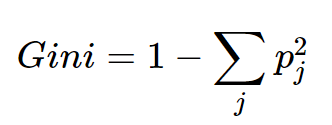

In [223]:
from IPython.display import Image
Image('gini.png')

### Gini index for a particular value of a particular attribute is calculated as follows:
    1. Divide the data into two groups based on the value and variable of interest
    2. Calculate gini index for each of the groups. Now we have 2 numbers, how can we have a single number to indicate the quality of the split.
            One way would be to average the gini index of the two groups. The problem here is that if a group has just one row, then the average of the two groups will be heavily skewed (and misinterpreted).Eg: average of 0 and 0.4 would be 0.2.So, we will be taking the weighted average. We multiply the gini index of each group by the proportion of instances in the group. In this way, we will be able to overcome the above mentioned problem. Eg: Weighted average of 0 and 0.4 would be 1/20 * 0 + 19/20 * 0.4 = 0.38 (Assuming 20 instances)
    3. The gini index is then summed up and minimum value of the gini index is preferred

In [105]:
def gini_index(groups, classes):
    """
    Calculates the gini index of two groups of data
    
    ### Input ###
    groups -> list of two groups each of which is a list of rows
    classes -> unique classes in the dataset
    
    ### Output ###
    gini -> Returns the gini index of the two groups split
    """
    n_instances = sum([len(group) for group in groups])
    gini = 0.0
    for group in groups:
        size = len(group)
        if size == 0:
            continue
        scores = 0.0
        for class_val in classes:
            prop = [row[-1] for row in group].count(class_val)/size
            scores += prop * prop
        gini += (1 - scores) * (size / n_instances)
    return gini        

In [106]:
print(gini_index([[[1, 1], [1, 0]], [[1, 1], [1, 0]]], [0, 1]))
print(gini_index([[[1, 0], [1, 0]], [[1, 1], [1, 1]]], [0, 1]))

0.5
0.0


In [107]:
def split_dataset(dataset, index, value):
    """
    Splits the dataset into two groups (left & right) based on the 'index' attribute & 'value'
    
    ### Input ###
    dataset -> Input data to be split
    index -> index of the column to split at
    value -> value of the column to split at
    
    ### Output ###
    left, right -> list of rows in the left node, list of rows in the right node
    """
    left, right = [],[]
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left,right

In [108]:
def get_best_split(dataset):
    """
    Gets the best possible split in the input dataset
    
    ### Input ###
    dataset -> List of rows on which splits needs to be evaluated
    
    ### Output ###
        Returns the dictionary of best index, best value to split, best gini & the groups that had best score
    """
    classes = list(set([row[-1] for row in dataset]))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = split_dataset(dataset, index, row[index])
            gini = gini_index(groups, classes)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {"index":b_index, "value":b_value, "gini":b_score, "groups":b_groups}            

In [181]:
dataset = [[2.771244718,1.784783929,0],
[1.728571309,1.169761413,0],
[3.678319846,2.81281357,0],
[3.961043357,2.61995032,0],
[2.999208922,2.209014212,0],
[7.497545867,3.162953546,1],
[9.00220326,3.339047188,1],
[7.444542326,0.476683375,1],
[10.12493903,3.234550982,1],
[6.642287351,3.319983761,1]]
split = get_best_split(dataset)

In [109]:
split

{'index': 0,
 'value': 6.642287351,
 'gini': 0.0,
 'groups': ([[2.771244718, 1.784783929, 0],
   [1.728571309, 1.169761413, 0],
   [3.678319846, 2.81281357, 0],
   [3.961043357, 2.61995032, 0],
   [2.999208922, 2.209014212, 0]],
  [[7.497545867, 3.162953546, 1],
   [9.00220326, 3.339047188, 1],
   [7.444542326, 0.476683375, 1],
   [10.12493903, 3.234550982, 1],
   [6.642287351, 3.319983761, 1]])}

In [110]:
def to_terminal(group):
    """
    Makes a set of rows in node to a leaf node
    
    ### Input ###
    group -> Set of rows to be set as leaf node
    
    ### Output ###
        Returns the most repeating class of the outcomes in the given set of rows
    """
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key = outcomes.count)

In [111]:
def split_node(node, max_depth, min_size, depth):
    """
    Splits a node recursively until max_depth is met, or min_size is met, or one of the nodes is empty
    
    ### Input ###
    node -> A dictionary returned by 'get_best_split()'
    max_depth -> maximum depth the tree can grow to
    min_size -> minimum number of samples needed to do a split
    depth -> current depth of the tree
    
    ### Output ###
        Returns nothing. It just keeps on adding key & values to the existing 'node' dictionary
    """
    left, right = node["groups"]
    del node["groups"]
    
    #Check for a no split
    if not left or not right:
        node["left"] = node["right"] = to_terminal(left+right)
        return
    
    #Check for the max depth
    if depth >= max_depth:
        node["left"], node["right"] = to_terminal(left), to_terminal(right)
        return
    #Check for the min sample size in the node & process left node recursively
    if len(left) <= min_size:
        node["left"] = to_terminal(left)
    else:
        node["left"] = get_best_split(left)
        split_node(node["left"], max_depth, min_size, depth+1)
    
    #Check for the min sample size in the node & process right node recursively
    if len(right) <= min_size:
        node["right"] = to_terminal(right)
    else:
        node["right"] = get_best_split(right)
        split_node(node["right"], max_depth, min_size, depth+1)

In [112]:
def build_tree(train, max_depth, min_size):
    """
    Starts building the decision tree
    
    ### Input ###
    train -> Input dataset
    max_depth -> maximum depth the tree can grow to
    min_size -> minimum number of samples needed to do a split
    
    ### Output ###
    root -> A master dictionary containing all the traversing path information
    """
    root = get_best_split(train)
    split_node(root, max_depth, min_size, 1)
    return root

In [113]:
def print_tree(node, depth = 0):
    """
    Prints the tree based on the indents to denote the depth of the tree
    
    ### Input ###
    node -> Input dictionary
    depth -> current depth of the tree
    ### Output ###
        Prints the decision tree
    """
    if isinstance(node, dict):
        print('%s[X%d < %.3f]' % ((depth * ' '),node['index']+1,node['value']))
        print_tree(node["left"], depth+1)
        print_tree(node["right"], depth+1)
    else:
        print('%s[%s]' % (depth*' ',node))

In [180]:
tree = build_tree(dataset,1,1)
print_tree(tree)

[X1 < 0.322]
 [1.0]
 [0.0]


In [115]:
tree

{'index': 0,
 'value': 6.642287351,
 'gini': 0.0,
 'left': {'index': 0,
  'value': 2.771244718,
  'gini': 0.0,
  'left': 0,
  'right': {'index': 0,
   'value': 2.771244718,
   'gini': 0.0,
   'left': 0,
   'right': 0}},
 'right': {'index': 0,
  'value': 7.497545867,
  'gini': 0.0,
  'left': {'index': 0,
   'value': 7.444542326,
   'gini': 0.0,
   'left': 1,
   'right': 1},
  'right': {'index': 0,
   'value': 7.497545867,
   'gini': 0.0,
   'left': 1,
   'right': 1}}}

In [120]:
def predict(node, row):
    """
    Makes a prediction for a given test row
    
    ### Input ###
    node -> Input dictionary
    row -> A row for which prediction needs to be made
    
    ### Output ###
        Returns the prediction for a particular row
    """
    if row[node["index"]]<node["value"]:
        if isinstance(node["left"], dict):
            return predict(node["left"],row)
        else:
            return node["left"]
    else:
        if isinstance(node["right"], dict):
            return predict(node["right"],row)
        else:
            return node["right"]

In [121]:
predict(tree, [6.1,1,0])

0

In [96]:
tree

{'index': 0,
 'value': 6.642287351,
 'gini': 0.0,
 'left': {'index': 0,
  'value': 2.771244718,
  'gini': 0.0,
  'left': 0,
  'right': {'index': 0,
   'value': 2.771244718,
   'gini': 0.0,
   'left': 0,
   'right': 0}},
 'right': {'index': 0,
  'value': 7.497545867,
  'gini': 0.0,
  'left': {'index': 0,
   'value': 7.444542326,
   'gini': 0.0,
   'left': 1,
   'right': 1},
  'right': {'index': 0,
   'value': 7.497545867,
   'gini': 0.0,
   'left': 1,
   'right': 1}}}

In [123]:
def load_csv(filename):
    """
    Loads the .csv file
    ###Input### 
        filename -> Name of the .csv file to be loaded
    ###Output### 
        dataset -> Returns the .csv file in the form of a python list
    """
    dataset = []
    with open(filename,"r") as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset

In [124]:
def str_column_to_float(dataset, column):
    """
    Changes the numeric column which is stored as strings to float dtype
    ###Input### 
        dataset -> The dataset containing the column
        column -> Index of the column which contains the numbers (stored as strings)
    ###Output### 
        None -> It changes the dtype of the column in the original dataset itself
    """
    for row in dataset:
        row[column] = float(row[column].strip())

In [125]:
def cross_validation_split(dataset, nfolds):
    """
    Performs the splitting of the dataset into "nfolds" folds
    ###Input### 
        dataset -> The entire dataset that needs to be scaled
        nfolds -> Number of folds to be used for cross validation
    ###Output### 
        dataset_split -> A list containing "nfolds" folds to be used for cross validation
    """
    dataset_split = []
    dataset_copy = list(dataset)
    fold_size = int(len(dataset)/nfolds)
    for _ in range(nfolds):
        fold = []
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

In [126]:
def accuracy_metric(actuals, predictions):
    """
    Calculates the accuracy of the predictions
    ###Input### 
        actuals -> Actual target values
        predictions -> Predicted target values
    ###Output### 
        acc -> Returns the accuracy of the predictions
    """
    correct = 0
    for i in range(len(actuals)):
        if actuals[i] == predictions[i]:
            correct += 1
    acc = (correct/len(actuals)) * 100.0
    return acc

In [134]:
def evaluate_algorithm(dataset, algorithm, nfolds, *args):
    """
    Evaluates any algorithm using the K-fold cross validation technique
    ###Input### 
        dataset -> Input dataset
        algorithm -> Function that performs K-NN and returns predictions
        nfolds -> Number of folds to be used in cross validation
        *args -> Variable number of arguments to be used in the function, if needed
    ###Output### 
        scores -> Returns a list of scores on the different folds used
    """
    folds = cross_validation_split(dataset, nfolds)
    scores = []
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set,[])
        test_set = list(fold)
        predictions = algorithm(train_set, test_set, *args)
        actuals = [row[-1] for row in test_set]
        accuracy = accuracy_metric(actuals, predictions)
        scores.append(accuracy)
    return scores

In [135]:
def CART(train, test, max_depth, min_size):
    """
    Takes the training data to build the tree and predicts for the test data
    
    ### Input ###
    train -> input dataset
    test -> dataset for which predictions needs to be made
    max_depth -> maximum depth the tree can grow to
    min_size -> minimum number of samples needed to do a split
    
    ### Output ###
    predictions -> List of predictions for each row in the test set
    """
    tree = build_tree(train, max_depth, min_size)
    predictions = []
    for row in test:
        pred = predict(tree, row)
        predictions.append(pred)
    return predictions

In [130]:
import os
os.getcwd()

'C:\\Users\\s5rxcy'

In [205]:
seed(1)
# load and prepare data
filename = 'data_banknote_authentication.csv'
dataset = load_csv(filename)
print(dataset[0])
# convert string attributes to integers
for i in range(len(dataset[0])):
    str_column_to_float(dataset, i)
# evaluate algorithm
n_folds = 5
max_depth = 5
min_size = 10
scores = evaluate_algorithm(dataset, CART, n_folds, max_depth, min_size)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

['3.6216', '8.6661', '-2.8073', '-0.44699', '0']
Scores: [96.35036496350365, 97.08029197080292, 97.44525547445255, 98.17518248175182, 97.44525547445255]
Mean Accuracy: 97.299%


Let's now validate our implementation with the sklearn implementation

In [169]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd

In [170]:
data = pd.read_csv('data_banknote_authentication.csv', names = ["V1","V2","V3","V4","Class"])

In [171]:
data.head()

,V1,V2,V3,V4,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [172]:
dtree = DecisionTreeClassifier(random_state = 1, max_depth = 5, min_samples_split = 10)

In [173]:
dtree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [174]:
scores = cross_val_score(dtree, data.drop("Class", axis = 1), data["Class"],cv = 5)

In [175]:
scores.mean()

0.970850696748507

# Benchmarking

### Our implementation

In [207]:
# evaluate algorithm
n_folds = 5
max_depth = 2
min_size = 10
scores = evaluate_algorithm(dataset, CART, n_folds, max_depth, min_size)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Scores: [91.97080291970804, 93.06569343065694, 88.32116788321169, 91.24087591240875, 90.87591240875912]
Mean Accuracy: 91.095%


### Sklearn's implementation

In [199]:
dtree = DecisionTreeClassifier(random_state = 1, max_depth = 2, min_samples_split = 10)
scores = cross_val_score(dtree, data.drop("Class", axis = 1), data["Class"],cv = 5)

In [201]:
dtree.fit(data.drop("Class", axis = 1), data["Class"])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [200]:
scores.mean()

0.9081725282017252

Visualize the trees to see if they have picked up same split points

In [211]:
tree = build_tree(dataset,2,1)
print_tree(tree)

[X1 < 0.322]
 [X2 < 7.627]
  [1.0]
  [0.0]
 [X3 < -4.384]
  [1.0]
  [0.0]


In [220]:
data[(data["V2"] > 7.627) & (data["V1"] <= 0.32)].shape

(105, 5)

In [208]:
os.system('dot -Tpng tree.dot -o tree.png')

0

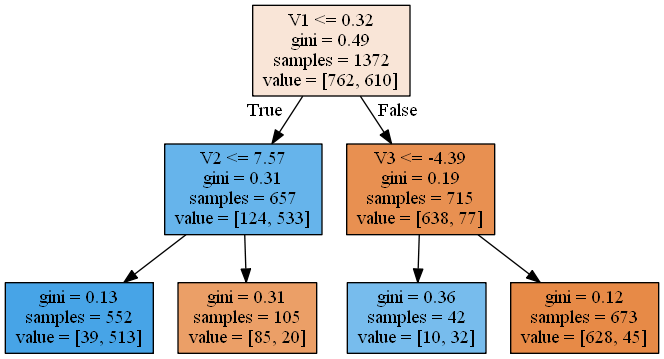

In [209]:
from IPython.display import Image
Image(filename = "tree.png")

We infer that our very own implementation of decision tree and sklearn's implementation is giving similar results :)